<a href="https://colab.research.google.com/github/jahreda/Spring2024/blob/main/g_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np
N0 = 2e7
lifetime = 64.4e-6
phase = 1.0
omega_over2pi = 229077.81
omega = omega_over2pi*np.pi*2
def func(t):
  return N0*np.exp(-t/lifetime)*(1+np.cos(omega*t+phase))

tmin = 0
tmax = 500e-6
nbin = 8000

ts = np.linspace(tmin,tmax,nbin)
vals = np.array([])
for t in ts:
  val = func(t)
  fluctuated = np.random.poisson(val,1)
  vals = np.append(vals,fluctuated[0])

#from google.colab import drive,files
#drive.mount('/content/drive')
#np.savetxt('g-2.txt',np.column_stack((ts,vals)),header='time(seconds) Ndecays')
#files.download('g-2.txt')

Saving g-2.txt to g-2 (2).txt


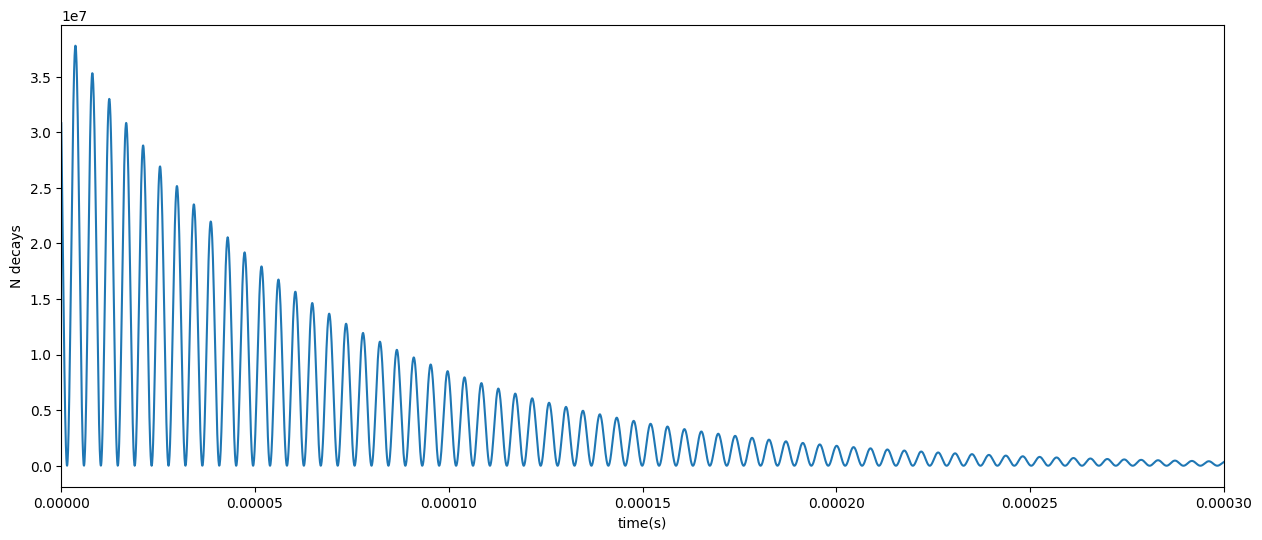

In [90]:
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()### g-2 file
all = np.genfromtxt('g-2.txt')
ts = all[:,0]
vals = all[:,1]
plt.figure(figsize=(15,6))
plt.plot(ts,vals)
plt.xlabel('time(s)')
plt.ylabel('N decays')
plt.xlim(0,0.0003)
plt.show()

Function: N0*exp^{-t/tau}*(1+cos(ωt+δ))

We have 3 parameters, N0, omega and phase

E = sum_i (y_i-N0*e^(-t/tau)*(1+cos(omega*t+δ)))^2

∂E / ∂N0 = sum_i -2*(y_i-N0*e^(-t/tau)*(1+cos(ωt+δ)))*(e^(-t/tau)*(1+cos(ωt+δ)))

∂E / ∂ω = sum_i 2*(y_i-N0*e^(-t/tau)*(1+cos(ωt+δ)))*(N0*t*e^(-t/tau)*(sin(ωt+δ)))

∂E / ∂δ= sum_i 2*(y_i-N0*e^(-t/tau)*(1+cos(ωt+δ)))*(N0*e^(-t/tau)*(sin(ωt+δ)))



In [102]:
from numpy import sqrt
tau = 64.4e-6
def func(t,N0,omega,phase):
  return N0*np.exp(-t/tau)*(1+np.cos(omega*t+phase))

def calcChi2(xs,ys,params,reduced = True): ### params = N0, omega, phase
  chi2 = 0
  for x,y in zip(xs,ys):
    expected = func(x,params[0],params[1],params[2])
    if(y < 1e-6): chi2 += 9 ### placeholder
    else: chi2 += ((y-expected)**2)/y
  if (reduced): return chi2/len(xs)
  else: return chi2

def gradient(xs,ys,params):
  gradN0 = 0
  gradOmega = 0
  gradDelta = 0
  for x,y in zip(xs,ys):
    denom = y
    if (denom < 1e-6): denom = 9
    gradN0 += -2*(y-func(x,params[0],params[1],params[2]))*(np.exp(-x/tau)*(1+np.cos(params[1]*x+params[2])))/denom
    gradOmega += 2*(y-func(x,params[0],params[1],params[2]))*(params[0]*x*np.exp(-x/tau)*np.sin(params[1]*x+params[2]))/denom
    gradDelta += 2*(y-func(x,params[0],params[1],params[2]))*(params[0]*np.exp(-x/tau)*np.sin(params[1]*x+params[2]))/denom
  return(gradN0,gradOmega,gradDelta)

params = [N0,omega,phase]
chi2 = calcChi2(ts,vals,params)
print(chi2)

1.0085847081251011


[15404226.0, 1439338.3299928769, 0]


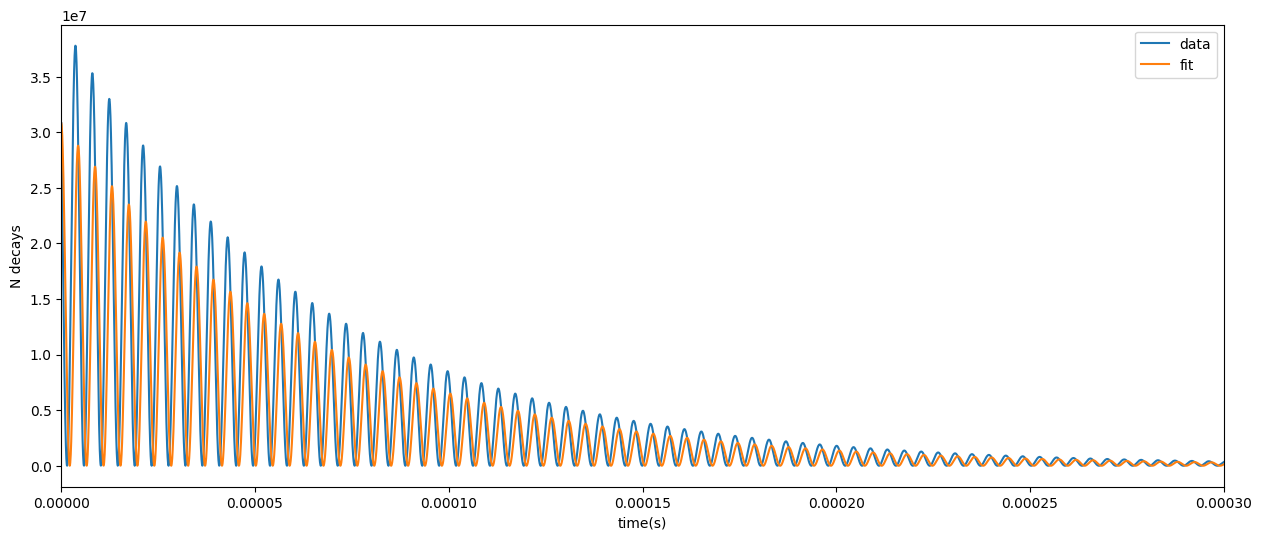

In [95]:
#  func = return N0*np.exp(-t/tau)*(1+np.cos(omega*t+phase))
## so at t = 0 (or first bin) we get val0 = N0*(1+cos(phase))
## ignoring the phase we get N0 = val0/2
## and we can find the minimum. this is at omega*tmin + phase = pi -> tmin = pi-phase/omega

### unfold the exponential to find omega
vals_unfolded = vals*np.exp(ts/tau)

#previous is the max
previous = vals_unfolded[0]

counter = 0
tmin = 0
for t,val in zip(ts,vals_unfolded):
  if (val > previous):
    tmin = t
    previous = val
    break
  else:
    previous = val
  counter = counter+1

params[0] = vals[0]/2
params[1] = omega
params[2] = 0
print(params)

plt.figure(figsize=(15,6))
plt.plot(ts,vals, label="data")
plt.plot(ts,func(ts, params[0],params[1],params[2]),label="fit")
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('N decays')
plt.xlim(0,0.0003)
plt.show()


[15000000.0, 1400000.0, 0.2]


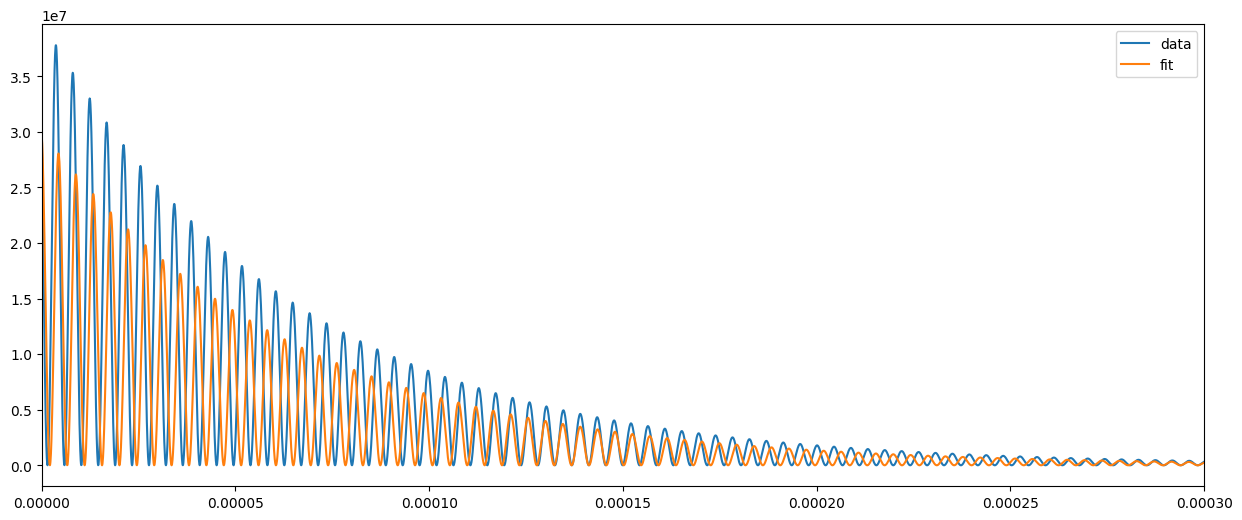

In [92]:
# print a best guess
params = [1.5e7, 1.4e6, 0.2]

print(params)

plt.figure(figsize=(15,6))
plt.plot(ts,vals, label="data")
plt.plot(ts,func(ts, params[0],params[1],params[2]),label="fit")
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('N decays')
plt.xlim(0,0.0003)
plt.show()


In [ ]:
lrdecay = .999

params = [1.5e7, 1.4e6, 0.2]

print(params,calcChi2(ts,vals,params))
lr0 = 1e-4
lr1 = 1e-6
lr2 = 1e-12
chi2s = []
N0s = []
omegas = []
phis = []
for iter in range(2000):
  chi2 = calcChi2(ts,vals,params)
  if (iter%100 == 0): print(iter,chi2,params)
  gradients = gradient(ts,vals,params)
  #print("iter = ",iter,"chi2 = ",calcChi2(ts,vals,params))
  #print("param 1",iter,gradients[1],params[1],params[1] - lr1*gradients[1])
  chi2s.append(chi2)
  N0s.append(params[0])
  omegas.append(params[1])
  phis.append(params[2])
  params[0] = params[0] - lr0*gradients[0]
  params[1] = params[1] - lr1*gradients[1]
  params[2] = params[2] - lr2*gradients[2]
  lr0 = lr0*lrdecay
  lr1 = lr1*lrdecay
  lr2 = lr2*lrdecay

plt.figure(figsize=(15,6))
plt.plot(ts,vals, label="data")
plt.plot(ts,func(ts, params[0],params[1],params[2]),label="fit")
plt.legend()
plt.xlim(0,0.0003)
plt.show()
print(params,calcChi2(ts,vals,params))

plt.plot(chi2s)
plt.xlabel("iteration")
plt.ylabel("chi2")
plt.yscale("log")
plt.show()

plt.plot(N0s)
plt.xlabel("iteration")
plt.ylabel("N0")
plt.show()

plt.plot(omegas)
plt.xlabel("iteration")
plt.ylabel("omega")
plt.show()

plt.plot(phis)
plt.xlabel("iteration")
plt.ylabel("phi")
plt.show()


[15000000.0, 1400000.0, 0.2] 2444981317.805465
0 2444981317.805465 [15000000.0, 1400000.0, 0.2]
100 1061117894.3769464 [14965902.374867773, 1403485.4586223506, 82.708307970976]
